In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
from datasets import load_dataset

try:
    # Load the dataset
    dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
    print(dataset)

    # Save the dataset to disk
    save_path = '/kaggle/working/medical_meadow_dataset'
    dataset.save_to_disk(save_path)
    print(f"Dataset saved successfully to {save_path}")
except Exception as e:
    print(f"An error occurred: {e}")

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 33955
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset saved successfully to /kaggle/working/medical_meadow_dataset


In [4]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [5]:
# Load the dataset from the saved arrow file
dataset = Dataset.from_file('/kaggle/working/medical_meadow_dataset/train/data-00000-of-00001.arrow')

# Convert to Pandas DataFrame for analysis
df = dataset.to_pandas()

In [6]:
# Prepare the data for training
X = df['input']
y = df['output']

In [10]:
# Filter out classes with less than 2 instances
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_df = df[df['output'].isin(valid_classes)]

In [11]:
# Update X and y after filtering
X = filtered_df['input']
y = filtered_df['output']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [14]:
# Define hyperparameter grids for different models
param_grids = {
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'random_forest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    }
}

In [15]:
# Train and evaluate models
results = {}
for model_name, param_grid in param_grids.items():
    if model_name == 'logistic_regression':
        model = LogisticRegression(max_iter=1000)
    elif model_name == 'svm':
        model = SVC()
    elif model_name == 'random_forest':
        model = RandomForestClassifier()
    
    clf = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    clf.fit(X_train_tfidf, y_train)
    
    y_pred = clf.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results[model_name] = {'accuracy': accuracy, 'f1': f1, 'best_params': clf.best_params_, 'y_pred': y_pred}

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Model: logistic_regression
Accuracy: 0.73
F1-score: 0.44
Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}

Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

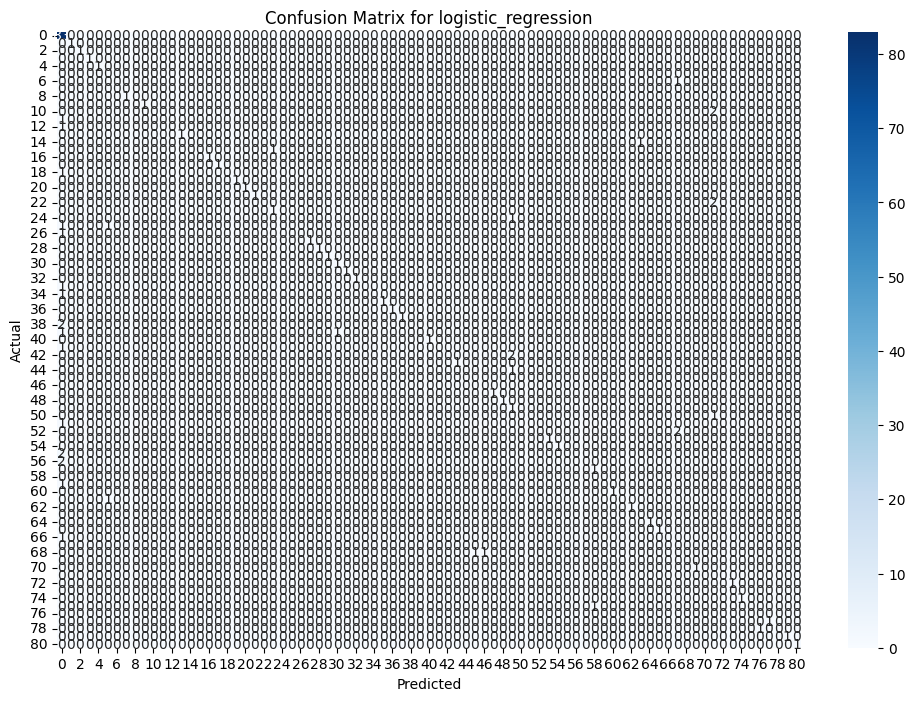

Model: svm
Accuracy: 0.80
F1-score: 0.63
Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

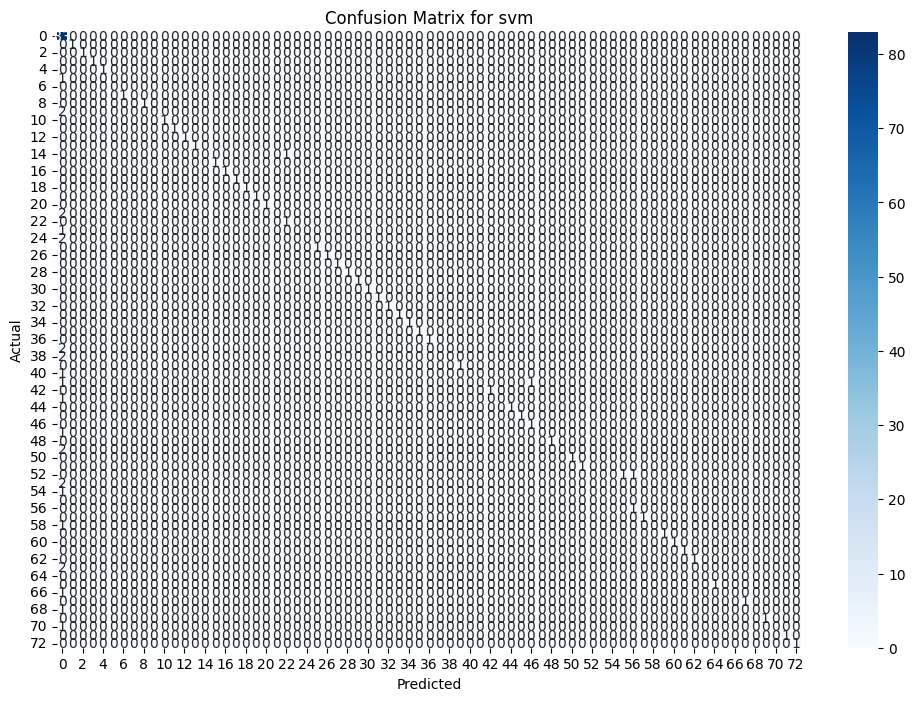

Model: random_forest
Accuracy: 0.73
F1-score: 0.44
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

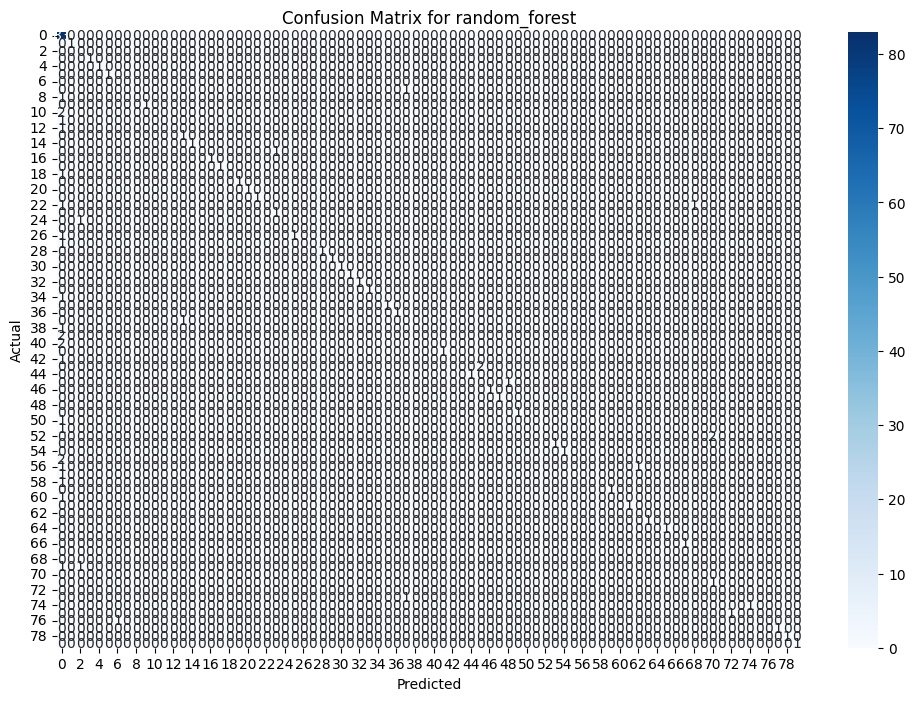

In [16]:
# Print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print(f"F1-score: {result['f1']:.2f}")
    print(f"Best hyperparameters: {result['best_params']}")
    print()
    
    # Detailed evaluation
    print("Classification Report:")
    print(classification_report(y_test, result['y_pred']))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, result['y_pred'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()